# Simple 2D classification

- This notebook explores fitting simple 2D structures using small ReLU-activated fully-connected feed-forward networks
- A single layer can fit more complicated structure with more units
- However, a single layer finds it challenging to fit nested structure (ie to move out of a local minimum to get to the global minimum) if the initial parameters start in the 'wrong' place
- An additional layer helps the optimizer use composite structures, allowing the optimizer to move in a space without the barrier between the local and global minima.

## Code

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn

# While all of these steps could be done easily on the CPU,
# it is good practice to choose a device.
TORCH_DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

In [2]:
class Optim:
    """A wrapper to run the optimization with some logging."""
    def __init__(self, model, loss_fn, input_gen, target_fn):
        self._model = model
        self._loss_fn = loss_fn
        self._input_gen = input_gen
        self._target_fn = target_fn

    def run(self, n_batches, learning_rate):
        optimizer = torch.optim.SGD(self._model.parameters(), lr=learning_rate)

        log_every = n_batches / 10
        for batch in range(n_batches):
            predictions = self._model(input_gen())
            targets = self._target_fn(inputs)
            batch_loss = self._loss_fn(predictions, targets)

            if batch % log_every < 1:
                print(f"Batch {batch}: loss={batch_loss.item():>7f}")

            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()


def plot_results(model, inputs, target_fn):
    """
    Plotting three results:
    1. The target classes
    2. The predicted classes from the model
    3. The ReLU boundaries in the first layer.
    """
    cpu_inputs = inputs.cpu()
    cpu_targets = target_fn(inputs).cpu()
    cpu_predicted = model(inputs).argmax(dim=1).detach().cpu()
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].scatter(cpu_inputs[:, 0], cpu_inputs[:, 1], c=cpu_targets)
    axs[1].scatter(cpu_inputs[:, 0], cpu_inputs[:, 1], c=cpu_predicted)
    
    layer = 0
    xs = torch.linspace(-5, 5, 101)
    params = list(model.stack[layer].parameters())
    # Make it still work when bias=False (ie params is only the weights)
    if len(params) == 1:
        w1 = params[0].cpu()
        b1 = torch.tensor(0)
    else:
        w1, b1 = params[0].cpu(), params[1].cpu()
    w1, b1 = w1.detach(), b1.detach()
    
    ys = (-xs.reshape(-1, 1) * w1[:, 0] - b1) / w1[:, 1]
    
    for i in range(ys.shape[1]):
        axs[2].plot(xs, ys[:, i])
    axs[2].set_xlim(-5, 5)
    axs[2].set_ylim(-5, 5)
    
    plt.show()


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
def get_circle(radius: float):
    """
    Inside the circle is 1, outside is 0
    """
    def circle_function(x):
        return (torch.pow(x, 2).sum(axis=1).sqrt() < radius).long()

    return circle_function

def get_donut(inner_radius, outer_radius):
    """
    The donut is 1, inside the inner or outside the outer is 0
    """
    def donut_function(x):
        return (
            (torch.pow(x, 2).sum(axis=1).sqrt() > inner_radius) & (torch.pow(x, 2).sum(axis=1).sqrt() < outer_radius)
        ).long()

    return donut_function


def get_square_hole_donut(inner_length, outer_radius):
    """
    The donut is 1, inside the inner or outside the outer is 0
    """
    def donut_function(x):
        return (
            ~(x.abs() < inner_length).all(axis=1) & (torch.pow(x, 2).sum(axis=1).sqrt() < outer_radius)
        ).long()

    return donut_function

## The models

In all of this, we look at a simple 2D space:

In [4]:
inputs = torch.tensor([
    (x, y)
    for x in torch.linspace(-5, 5, 101)
    for y in torch.linspace(-5, 5, 101)
]).to(TORCH_DEVICE)
input_gen = lambda: inputs

### 1 hidden layer

First, we fit 3 hidden units to a circle. The ReLU defines in the 2D input space - on one side the output is zero, and the other the output is proportional to the distance from the line.

There are 2 ways to create a circle from the ReLUs, either 1) have them pass through the center, or 2) have them ring around the perimeter. This case picks the former, but we'll see cases later that pick the latter.

Batch 0: loss=0.919008
Batch 1000: loss=0.066462
Batch 2000: loss=0.056094
Batch 3000: loss=0.051640
Batch 4000: loss=0.049162
Batch 5000: loss=0.047625
Batch 6000: loss=0.046473
Batch 7000: loss=0.045696
Batch 8000: loss=0.045112
Batch 9000: loss=0.044660


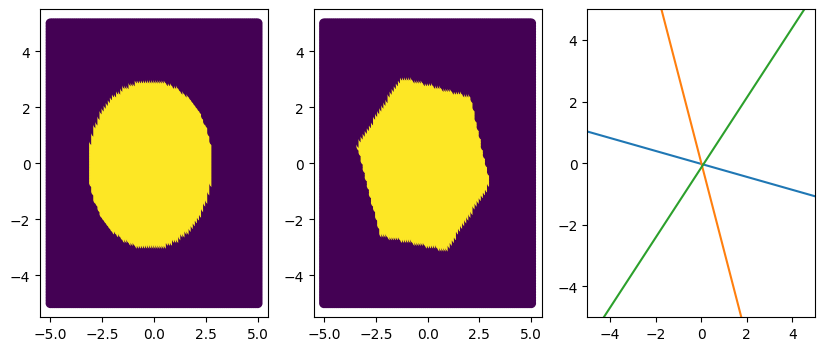

In [5]:
class Network(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(dim_in, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out, bias=True),
        )

    def forward(self, x):
        return self.stack(x)

set_seed(12345678)
model = Network(2, 3, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_circle(3)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

More hidden units make the circle smoother

Batch 0: loss=0.539945
Batch 1000: loss=0.030158
Batch 2000: loss=0.058990
Batch 3000: loss=0.017313
Batch 4000: loss=0.021627
Batch 5000: loss=0.021831
Batch 6000: loss=0.034685
Batch 7000: loss=0.010782
Batch 8000: loss=0.010050
Batch 9000: loss=0.009512


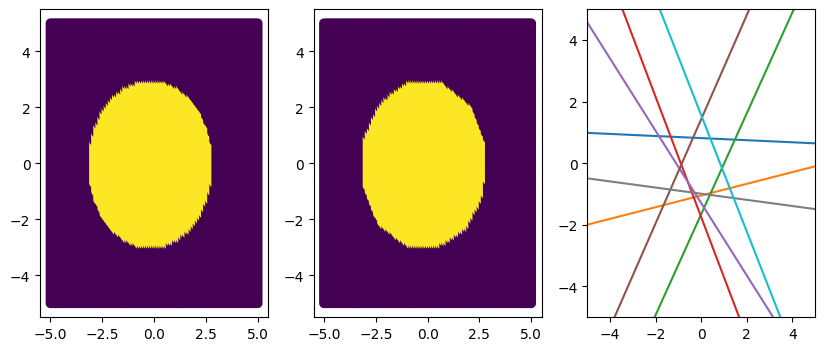

In [6]:
set_seed(12345678)
model = Network(2, 10, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_circle(3)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

3 hidden units can't fit the donut, but 10 can come close

Batch 0: loss=0.436395
Batch 1000: loss=0.212912
Batch 2000: loss=0.178752
Batch 3000: loss=0.146285
Batch 4000: loss=0.131793
Batch 5000: loss=0.125186
Batch 6000: loss=0.120635
Batch 7000: loss=0.118249
Batch 8000: loss=0.115168
Batch 9000: loss=0.113119


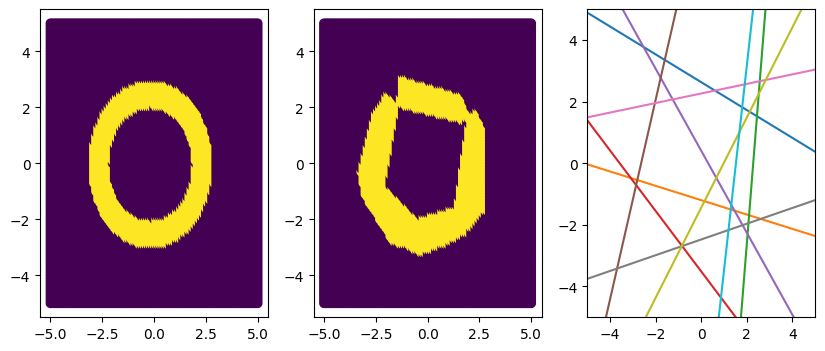

In [7]:
set_seed(12345678)
model = Network(2, 10, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_donut(2, 3)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=0.5)

plot_results(model, inputs, target_fn)

However, it finds it more challenging to fit a donut with a smaller hole in the middle. This is because the 'no hole' solution is a local minimum - moving one or more ReLUs into the gap will make the solution worse before getting better, and there isn't a large enough source of noise to get them across. In this case, the solution picks the 'ReLUs ring' version.

Batch 0: loss=0.673627
Batch 1000: loss=0.333761
Batch 2000: loss=0.315879
Batch 3000: loss=0.307122
Batch 4000: loss=0.303716
Batch 5000: loss=0.300978
Batch 6000: loss=0.299347
Batch 7000: loss=0.297974
Batch 8000: loss=0.296874
Batch 9000: loss=0.295968


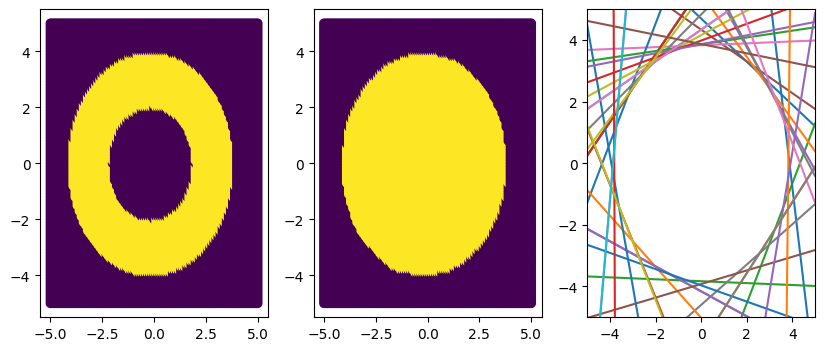

In [8]:
set_seed(12345678)
model = Network(2, 50, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_donut(2, 4)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

But with enough hidden units, it can find the hole in the donut (probably becuase enough ReLUs started in the center).

Batch 0: loss=0.687272
Batch 1000: loss=0.270167
Batch 2000: loss=0.211523
Batch 3000: loss=0.158062
Batch 4000: loss=0.151902
Batch 5000: loss=0.111130
Batch 6000: loss=0.110054
Batch 7000: loss=0.129256
Batch 8000: loss=0.094302
Batch 9000: loss=0.085861


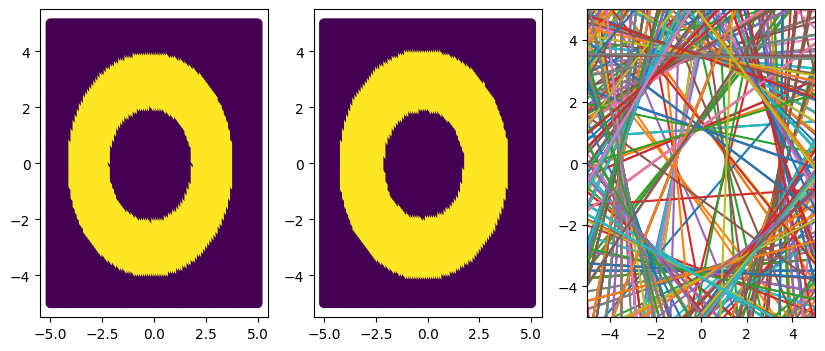

In [9]:
set_seed(12345678)
model = Network(2, 1000, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_donut(2, 4)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

### 2 hidden layers

From the above, in practice it takes a large number of hidden layers to 'find' the hole in a doughy donut. However, a second hidden layer finds this task much easier.

Batch 0: loss=0.961438
Batch 1000: loss=0.375405
Batch 2000: loss=0.329249
Batch 3000: loss=0.306994
Batch 4000: loss=0.286600
Batch 5000: loss=0.278873
Batch 6000: loss=0.262616
Batch 7000: loss=0.254399
Batch 8000: loss=0.257573
Batch 9000: loss=0.248797


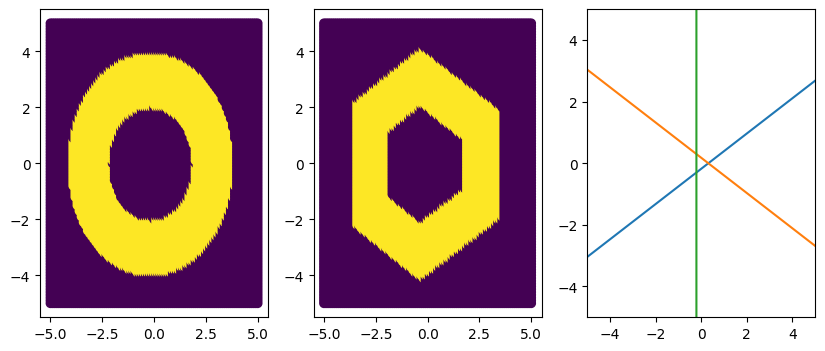

In [10]:
class Network2Layer(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(dim_in, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out, bias=True),
        )

    def forward(self, x):
        return self.stack(x)

set_seed(1234567)
model = Network2Layer(2, 3, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_donut(2, 4)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

If we change the donut hole to a square, the 3 unit version still finds 2 hexagons

Batch 0: loss=0.978545
Batch 1000: loss=0.367544
Batch 2000: loss=0.336890
Batch 3000: loss=0.315707
Batch 4000: loss=0.301701
Batch 5000: loss=0.289496
Batch 6000: loss=0.280607
Batch 7000: loss=0.272450
Batch 8000: loss=0.267583
Batch 9000: loss=0.261342


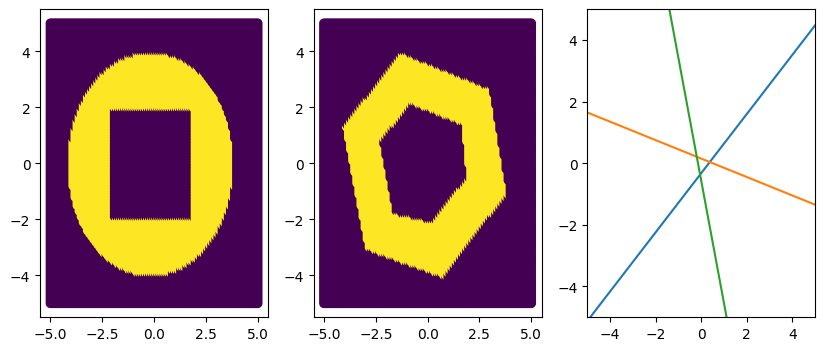

In [11]:
set_seed(1234567)
model = Network2Layer(2, 3, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_square_hole_donut(2, 4)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

But a 5 unit layer is able to separate out the shapes

Batch 0: loss=0.836957
Batch 1000: loss=0.212866
Batch 2000: loss=0.144951
Batch 3000: loss=0.095422
Batch 4000: loss=0.177695
Batch 5000: loss=0.196808
Batch 6000: loss=0.209217
Batch 7000: loss=0.069311
Batch 8000: loss=0.054269
Batch 9000: loss=0.055102


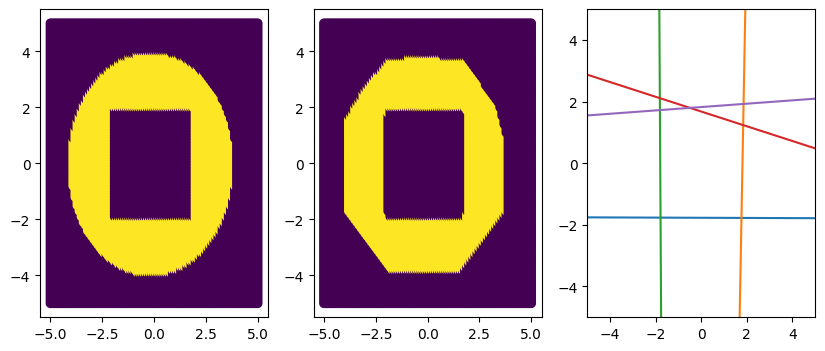

In [12]:
set_seed(1234567)
model = Network2Layer(2, 5, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_square_hole_donut(2, 4)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=1.0)

plot_results(model, inputs, target_fn)

The extra layer finds it much easier to find and grow composite structures.

The single layer needs those pieces to move close together.

There is more likely to be a 'barrier' in the objective function in the single layer.
ie the gradients are against each individual piece moving across the barrier.

But when dealing with the extra layer, don't have to move across the boundary - as the composite structure may have better gradients.

### Adding a transformer-like layer

Batch 0: loss=1.199832
Batch 1000: loss=0.041073
Batch 2000: loss=0.034169
Batch 3000: loss=0.030543
Batch 4000: loss=0.028193
Batch 5000: loss=0.026427
Batch 6000: loss=0.025103
Batch 7000: loss=0.024054
Batch 8000: loss=0.023201
Batch 9000: loss=0.022495


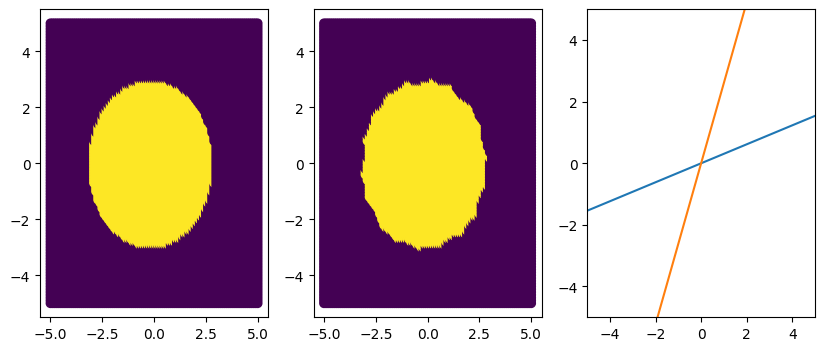

In [13]:
class Transf(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(n, n))

    def forward(self, x):
        def prod(xx):
            return xx @ (xx.outer(xx) * self.a)
        return torch.vmap(prod, 0)(x) 

class Network(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.stack = nn.Sequential(
            Transf(dim_in),
            nn.Linear(dim_in, dim_hidden, bias=True),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_out, bias=True),
        )

    def forward(self, x):
        return self.stack(x)

set_seed(12345678)
model = Network(2, 3, 2).to(TORCH_DEVICE)
loss_fn = nn.CrossEntropyLoss()
target_fn = get_circle(3)
optim = Optim(model, loss_fn, input_gen, target_fn)
optim.run(n_batches=10000, learning_rate=0.25)

plot_results(model, inputs, target_fn)